In [16]:
%pylab inline
from parcels import FieldSet, Field, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
import cartopy
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import math as math
import matplotlib.animation as animation
import datetime as datetime
sys.path.insert(1, '/Users/f103457/surfdrive/GalapagosAnalysis/functions')
from ParticlePlotFunctions import *
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['figsize', 'indices']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [17]:
namefile = '../../input/particles/DrifterRelease_200615.nc'
Traj = ReadTrajectories(namefile)
release_time = 293  #number of releases at specific location 
release_loc = 675   #number of release locations
total_particles = Traj['lon'].shape[0]

startlon = Traj['lon'][0:release_loc,0]
startlat = Traj['lat'][0:release_loc,0]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


(-3.5, 3)

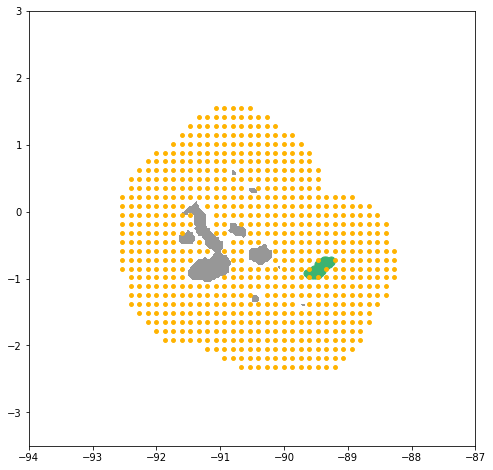

In [18]:
# load bathymetry, lon, lat, land mask and tag different islands

galapagos_domain = [-94, -87, -3.5, 3]
# Isla Pinta = 'Pinta'
pinta_extent = [-91, -90.5, 0.5, 1,'Pinta']
# Isla Marchena = 'Marchena'
marchena_extent = [-90.6, -90, 0.2, 0.5,'Marchena']
# Isla Santiago = 'Santiago'
santiago_extent = [-90.9, -90.5, -0.5, 0,'Santiago']
# Isla Santa Cruz = 'Cruz'
cruz_extent = [-90.7, -90.15, -0.8, -0.45,'Cruz']
# Isla Santa Fe = 'Fe'
fe_extent = [-90.15,-90,-1,-0.75,'Fe']
# Isla de San Cristobal = 'Cristobal'
cristobal_extent = [-89.7, -89, -1, -0.6,'Cristobal']
# Isla Espanola
espanola_extent = [-90, -89.5, -1.5, -1.2,'Espanola']
# Isla Floreana
floreana_extent = [-90.6, -90.2, -1.5, -1.2,'Floreana']
# Isla Isabela = 'Isabela' -> remainder of points
# Isla Fernandina = 'Fernandina' 
fernandina = np.concatenate((np.arange(351,357),
                             np.arange(367,374),
                             np.arange(384,392),
                             np.arange(399,407),
                             np.arange(416,423),
                             np.arange(437,441),
                             np.arange(457,458)))


bathy_file = '../../input/modelfields/MITgcm4km/RGEMS3_Surf_grid.nc'
dfile = Dataset(bathy_file)
bathy = dfile.variables['Depth'][200:450,300:550]
lat = dfile.variables['YG'][200:450]
lon = dfile.variables['XG'][300:550]
bathy = np.where(bathy<1, nan, bathy)
mask = np.where(isnan(bathy), 0, nan)
landmask = np.where(isnan(bathy))
islands = {}
islands['lon'] = lon[landmask[1][:]]
islands['lat'] = lat[landmask[0][:]] 
islands['island'] = ['']*islands['lon'].shape[0]

for index in range(islands['lon'].shape[0]):
    if (islands['lon'][index] > pinta_extent[0] and
        islands['lon'][index] < pinta_extent[1] and
        islands['lat'][index] > pinta_extent[2] and
        islands['lat'][index] < pinta_extent[3]):
        islands['island'][index] = pinta_extent[4]
    elif (islands['lon'][index] > marchena_extent[0] and
          islands['lon'][index] < marchena_extent[1] and
          islands['lat'][index] > marchena_extent[2] and
          islands['lat'][index] < marchena_extent[3]):
        islands['island'][index] = marchena_extent[4] 
    elif (islands['lon'][index] > santiago_extent[0] and
          islands['lon'][index] < santiago_extent[1] and
          islands['lat'][index] > santiago_extent[2] and
          islands['lat'][index] < santiago_extent[3]):
        islands['island'][index] = santiago_extent[4] 
    elif (islands['lon'][index] > cruz_extent[0] and
          islands['lon'][index] < cruz_extent[1] and
          islands['lat'][index] > cruz_extent[2] and
          islands['lat'][index] < cruz_extent[3]):
        islands['island'][index] = cruz_extent[4] 
    elif (islands['lon'][index] > fe_extent[0] and
          islands['lon'][index] < fe_extent[1] and
          islands['lat'][index] > fe_extent[2] and
          islands['lat'][index] < fe_extent[3]):
        islands['island'][index] = fe_extent[4] 
    elif (islands['lon'][index] > cristobal_extent[0] and
          islands['lon'][index] < cristobal_extent[1] and
          islands['lat'][index] > cristobal_extent[2] and
          islands['lat'][index] < cristobal_extent[3]):
        islands['island'][index] = cristobal_extent[4]
    elif (islands['lon'][index] > espanola_extent[0] and
          islands['lon'][index] < espanola_extent[1] and
          islands['lat'][index] > espanola_extent[2] and
          islands['lat'][index] < espanola_extent[3]):
        islands['island'][index] = espanola_extent[4]
    elif (islands['lon'][index] > floreana_extent[0] and
          islands['lon'][index] < floreana_extent[1] and
          islands['lat'][index] > floreana_extent[2] and
          islands['lat'][index] < floreana_extent[3]):
        islands['island'][index] = floreana_extent[4]
    elif index in fernandina:
        islands['island'][index] = 'Fernandina'
    else:
        islands['island'][index] = 'Isabela'

# check to see whether island points are correct

figsize=(8,8)
map_extent = galapagos_domain
fig, axs = plt.subplots(1, 1, figsize=figsize)
axs.contourf(lon,lat,mask,cmap='Greys',vmin=-1,vmax=1)
for index in range(islands['lon'].shape[0]):
    if islands['island'][index] == 'Cristobal':
        axs.scatter(islands['lon'][index],islands['lat'][index],s=50,c='mediumseagreen')
axs.scatter(startlon,startlat,s=15,c=(1,0.7,0))
axs.set_xlim(map_extent[0:2])
axs.set_ylim(map_extent[2:4])

#plt.savefig('release_locations.png', dpi=300)

In [19]:
# get particle and time when beaching at a specific land location
# NOW: only for one island -> Espanola

beaching_distance = 0.033 #unit lonlat degree
arrive_where = np.zeros((islands['lon'].shape[0]))
beaching = {}
beaching['particle']=[]
beaching['time']=[]
beaching['island']=['']

island = 'Cristobal'

for i, land in enumerate(islands['island']):
    if land == island:
        print(i)
        dist = (islands['lon'][i]-Traj['lon'])**2 + (islands['lat'][i]-Traj['lat'])**2
        pbeach = np.where(dist<beaching_distance**2)
        particles, indices = np.unique(pbeach[0][:], return_index = True)
        time_index = pbeach[1][indices]
        island_tag = [0]*len(particles)
   
        arrive_where[i]=len(particles)    
        beaching['particle'].extend(particles)
        beaching['time'].extend(time_index)
        beaching['island'].append(island_tag)

64


/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less


65
66
67
68
89
90
91
92
93
94
95
116
117
118
119
120
121
142
143
144
145
146
167
168
169
170
171
193
194
195
196
197
198
223
224
225
226
227
228
254
255
256


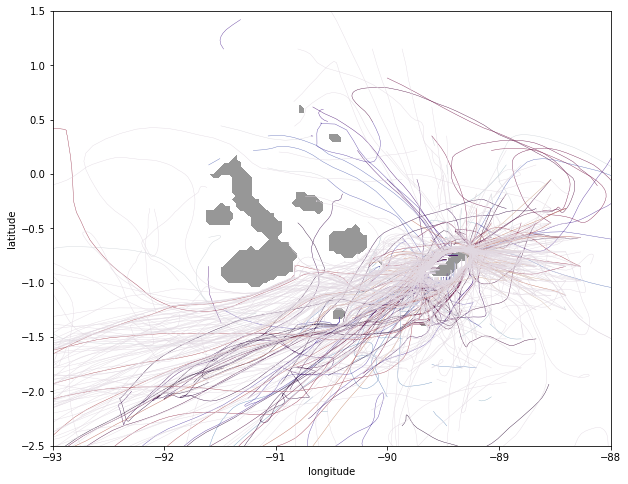

In [12]:
# figure for instagram
figsize=(10,8)
map_extent = [-93,-88, -2.5, 1.5]
fig, ax = plt.subplots(figsize=figsize)
ax.contourf(lon,lat,mask,cmap='Greys',vmin=-1,vmax=1) 
ax.set_xlabel('longitude')                 
ax.set_ylabel('latitude') 
ax.set_xlim(map_extent[0:2])
ax.set_ylim(map_extent[2:4])

particle, indices = np.unique(beaching['particle'][:], return_index = True)
cmap = matplotlib.cm.get_cmap('twilight')

for i,p in enumerate(particle[0::5]):
    beachtime = beaching['time'][indices[i]] 
    plat = Traj['lat'][p,0:beachtime]
    plon = Traj['lon'][p,0:beachtime]
    ax.plot(plon, plat, linewidth=0.4, color=cmap(i/len(particles[0::5])))


plt.savefig('pathways_instagram.png',dpi=300)

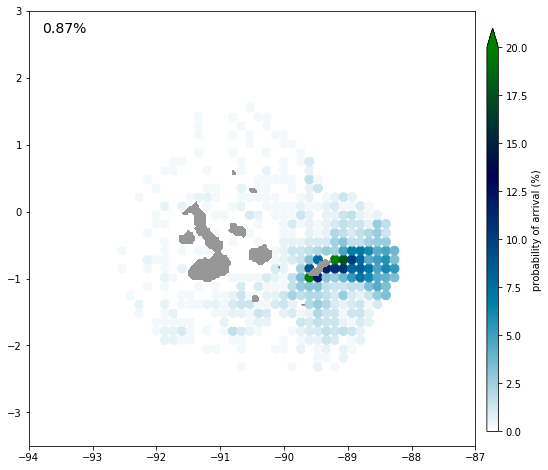

In [20]:
# plot probability of arrival for specific island


probability_of_arrival = np.zeros((release_loc))

particle, indices = np.unique(beaching['particle'][:], return_index = True)

for p in particle:
    index_loc = p%release_loc
    probability_of_arrival[index_loc] += 1


figsize=(8,8)
fig, axs = plt.subplots(1, 1, figsize=figsize)

im = axs.scatter(startlon,startlat,s=80,
                 c=probability_of_arrival/release_time*100,
                 cmap='ocean_r',
                 vmin=0,vmax=20) 
axs.contourf(lon,lat,mask,cmap='Greys',vmin=-1,vmax=1)

axs.set_xlim(galapagos_domain[0:2])
axs.set_ylim(galapagos_domain[2:4])
axs.text(0.03,0.95,'%.2f'%(np.sum(probability_of_arrival)/total_particles*100)+'%',
                    fontsize=14, 
                    transform = axs.transAxes)

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, extend='max')
cbar.ax.set_ylabel('probability of arrival (%)')

plt.savefig('probability_of_arrival.pdf')

/opt/anaconda3/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


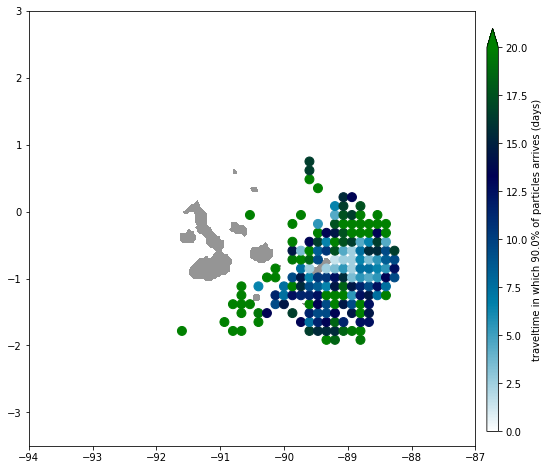

In [14]:
# time from release to arrival

traveltime = np.zeros((release_loc,release_time))
binmax = 100
binstep = 1
threshold = 0.9
bins=np.arange(0,binmax,binstep)

particle, indices = np.unique(beaching['particle'][:], return_index = True)
time_in_days = (np.array(beaching['time'])[indices]*6)/24

for i,p in enumerate(particle):
    index_loc = p%release_loc
    index_time = math.floor(p/release_loc)
    traveltime[index_loc,index_time] = time_in_days[i]

traveltime[traveltime==0]=nan
lifetime_minimum = np.zeros((release_loc))
for t in range(release_loc):  
    if np.any(traveltime[t,:] > 0):
        selection = traveltime[t,:]
        selection = selection[~isnan(selection)]
        n, bins = np.histogram(selection, bins, density=True)
        maxloc = np.where(np.cumsum(n*binstep)>threshold)[0][0]
        lifetime_minimum[t]=bins[maxloc]+binstep/2

figsize=(8,8)
map_extent = galapagos_domain
fig, axs = plt.subplots(1, 1, figsize=figsize)

lifetime_minimum[probability_of_arrival/release_time*100<1]=nan

axs.contourf(lon,lat,mask,cmap='Greys_r',vmin=-1,vmax=1)
im=axs.scatter(startlon,startlat,s=80,
            c=lifetime_minimum,
            cmap='ocean_r',
            vmin=0,vmax=20) 
axs.set_xlim(map_extent[0:2])
axs.set_ylim(map_extent[2:4])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, extend='max')
cbar.ax.set_ylabel('traveltime in which ' + str(threshold*100) + '% of particles arrives (days)')
    
plt.savefig('time_until_arrival.pdf')

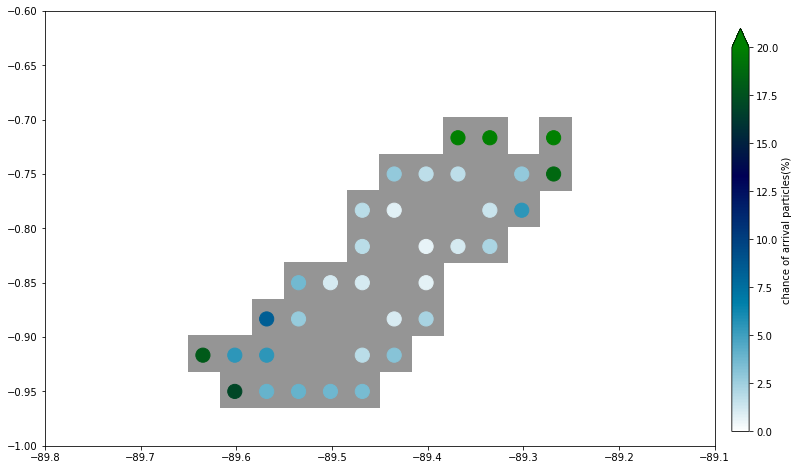

In [21]:
# scatter where and how many particles arrive

map_extent=[-89.8,-89.1,-1,-0.6]

figsize=(12,8)
fig, axs = plt.subplots(1, 1, figsize=figsize)

arrive_where=np.where(arrive_where==0, nan, arrive_where)

axs.pcolor(lon-0.015,lat-0.015,mask,cmap='Greys',vmin=-1,vmax=1)
im=axs.scatter(lon[landmask[1][:]],lat[landmask[0][:]],s=200,
            c=arrive_where/np.sum(probability_of_arrival)*100,
            cmap='ocean_r',
            vmin=0, vmax=20)

axs.set_xlim(map_extent[0:2])
axs.set_ylim(map_extent[2:4])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, extend='max')
cbar.ax.set_ylabel('chance of arrival particles(%)')

plt.savefig('location_of_arrival.pdf')

In [8]:
print(lon[2]-lon[1])

0.033332825


In [ ]:
# pathway from release to arrival

bins = [np.arange(galapagos_domain[0],galapagos_domain[1], 0.1), 
        np.arange(galapagos_domain[2],galapagos_domain[3], 0.1)]
pmap = np.zeros([len(bins[0])-1,len(bins[1])-1], dtype=float)

particle, indices = np.unique(beaching['particle'][:], return_index = True)

for i,p in enumerate(particle):
    beachtime = beaching['time'][indices[i]]
    plon = Traj['lon'][p,0:beachtime]
    plat = Traj['lat'][p,0:beachtime]
    H, xe, ye = np.histogram2d(plon,plat,bins=bins)
    H[H > 0]=1
    pmap += H    

pmap=pmap/len(particle)

# Make plot with histogram and mask land
figsize=(10,8)
fig, ax = plt.subplots(figsize=figsize)

vmax = 0.1
pmap[pmap==0]=nan
fig1 = ax.pcolor(bins[0][:-1],bins[1][:-1],pmap.T,           
                  cmap='GnBu',
                   vmin=0,
                   vmax=vmax)    
ax.set_title('particle density')          
ax.set_xlabel('longitude')                 
ax.set_ylabel('latitude') 
cbar = plt.colorbar(fig1, ax=ax)
cbar.ax.set_ylabel('particle density')

ax.contourf(lon,lat,mask,cmap='Greys',vmin=-1,vmax=1)
ax.set_xlim(galapagos_domain[0:2])
ax.set_ylim(galapagos_domain[2:4])

ax.hlines(-5,-85,-80,color='grey',linewidth=10)

#plt.savefig('../../results/figures/MITgcm_parcelsdensity_humbolt.pdf')

In [ ]:
# make a movie

map_extent = galapagos_domain
pylab.rcParams['figure.figsize'] = (10, 8)
Zmin = 10
Zmax = 4500

particle, indices = np.unique(beaching['particle'][:], return_index = True)

plat=np.zeros((len(particle),Traj['lat'].shape[1]))
plon=np.zeros((len(particle),Traj['lat'].shape[1]))
ptime=Traj['time'][0:len(particle),:]

for i,p in enumerate(particle):
    beachtime = beaching['time'][indices[i]] 
    plat[i,0:beachtime] = Traj['lat'][p,0:beachtime]
    plon[i,0:beachtime] = Traj['lon'][p,0:beachtime]
    ptime[i,0:beachtime] = Traj['time'][p,0:beachtime]

plottimes = np.arange(np.nanmin(ptime), np.nanmax(ptime), dtype='datetime64[D/4]')

fig, ax = plt.subplots(1,1)

levels = np.linspace(Zmin, Zmax, 41)
fig1 = ax.contourf(lon,lat,bathy,       
                      levels = levels,    
                      cmap='bone',       
                      extend='both',      
                      origin='lower')              
ax.set_xlabel('longitude')                 
ax.set_ylabel('latitude') 
ax.set_xlim(map_extent[0:2])
ax.set_ylim(map_extent[2:4])
ax.set_facecolor('gray')

t=0
b = np.where(np.logical_and(ptime >= plottimes[t], ptime < plottimes[t+1]))
scat = ax.scatter(plon[b], plat[b], s=30, c=(1,0.7,0))
ttl = ax.set_title('Particle location on ' + str(plottimes[0]))
#frames = np.arange(0, len(plottimes)-1)
frames = np.arange(0,500)

def animate(t):
    b = np.where(np.logical_and(ptime >= plottimes[t], ptime < plottimes[t+1]))
    scat.set_offsets(np.vstack((plon[b], plat[b])).transpose())
    particle_color = (1,0.7,0)
    scat.set_color(particle_color)
    ttl.set_text('Particle location on ' + str(plottimes[t]))
    return scat,

ax.set_xlim(map_extent[0:2])
ax.set_ylim(map_extent[2:4])

anim = animation.FuncAnimation(fig, animate, frames=frames, interval=100, blit=True)
anim

anim.save('cristobalparticles.gif', writer='imagemagick', fps=10)